**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# Using machine learning to solve a multiclass classification problem with scikit-learn

## Abstract

This project report studies the problem of assigning a genre label to a song using supplied rhythm, chroma and MFCC data, which is then solved using machine learning methods provided by scikit-learn. The solution involves using the MFCC data to construct a preprocessed feature matrix and then using scikit-learn's SVC estimator to build a multiclass classifier. Supplied feature and label data is split into training and test data sets. The solution is able to reach an accuracy of approximately 60.0% and a log-loss error of 1.00 using the local test data, and an accuracy of 59.3% and a log-loss error of 0.27 using the Kaggle test data set. All in all, the solution is simple and satisfactory, but there is certainly room for objective improvement.



## 1. Introduction

Machine learning is a branch of computer science where a mathemathical model is "taught" to implement a mapping from a feature space, i.e. the data observations, to a label space, i.e. deductions from the data. The features (observations) can be measurements, sensor readings or anything easily quantifiable. Labels are more complex since there isn't necessarily a strong connection from the features to a certain label. Machine learning allows the creation of a trained model that attempts to build this connection by analysing the data via mathematical means.

This report studies a problem where the system is presented with measurement data from a song of unknown genre. The aim is to build a model that can map these measurements (features) to a certain genre (label) with sufficient accuracy using the machine learning framework scikit-learn. Two different solutions are required: the first will give a single label (best guess) as output, and the second will output a probability for each possible label. Accuracy will be measured with two methods, one for each solution. The single output solution will be scored with a percentage of correct guesses versus incorrect guesses. The multiple output solution will be quantified with a log-loss error rating, with zero being a perfect score.

The project is motivated by the real challenge of automatically identifying a song's genre without human assistance. An automated solution can be useful in song recognition software and music library organization software, among others. The results of this project are scored in a Kaggle competition that compares the accuracy of different competing solutions.

The second chapter will give a brief introduction to the provided data set that is to be used as training data, as well as visualisations and observations about the data. The third chapter describes the methods and technology used in the solution. The fourth chapter outlines the results acquired with the solution. The fifth chapter discusses the implications of the results and gives criticism about their quality.

The primary sources used in this report are the official documentation of scikit-learn and various free online resources aimed at beginners in the field of machine learning.

## 2. Data analysis

The code below declares all the needed external libraries for our solution. Few helper functions for reading the training and test data is declared as well.



In [1]:
# Imports
import pandas
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
from random import sample
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

In [2]:
# some constants for feature matrices
RHYTHM_COUNT = 7 * 24
CHROMA_COUNT = 12 * 4
MFCC_COUNT = 12 * 4

HEADER = list(['Rhythm'] * RHYTHM_COUNT)
HEADER.extend(['Chroma'] * CHROMA_COUNT)
HEADER.extend(['MFCC'] * MFCC_COUNT)


# API #

def Acc_train_data():
    return Accuracy_data("train_data.csv")


def Acc_train_labels():
    return pandas.read_csv("Accuracy_data/train_labels.csv", header=None)


def Acc_test_data():
    return Accuracy_data("test_data.csv")


def Log_loss_train_data():
    return Log_loss_data("train_data.csv")


def Log_loss_train_labels():
    return pandas.read_csv("Log_Loss_data/train_labels.csv", header=None)


def Log_loss_test_data():
    return Log_loss_data("test_data.csv")


def Accuracy_data(filename):
    data = pandas.read_csv("Accuracy_data/" + filename, header=None, names=HEADER)
    return data


def Log_loss_data(filename):
    data = pandas.read_csv("Log_Loss_data/" + filename, header=None, names=HEADER)
    return data


# API #

The training data consists of 4363 songs, each song having 264 features. Each feature vector has 264 dimensions: 168 values for rhythm, 48 for chroma and 48 for MFCC.

The code below plots the average rhythm (low, mid and high bands), chroma and MFCC for each of the labels of the training data.

Reading data from files...


C:\Anaconda\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


Shaping data...


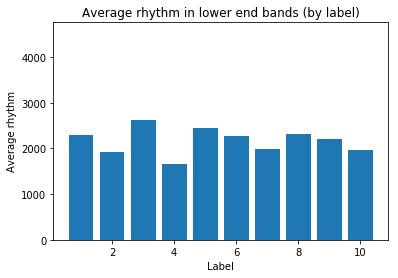

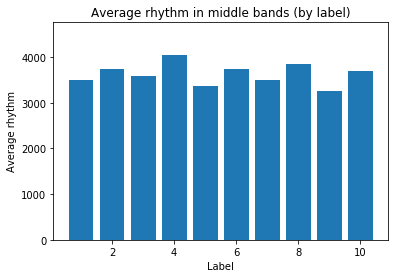

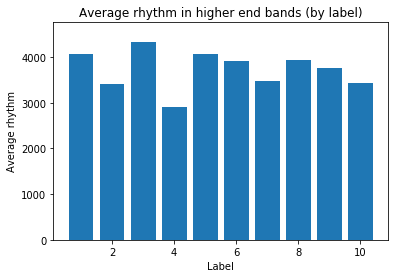

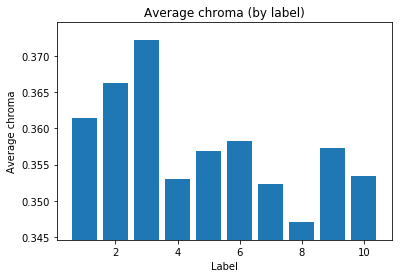

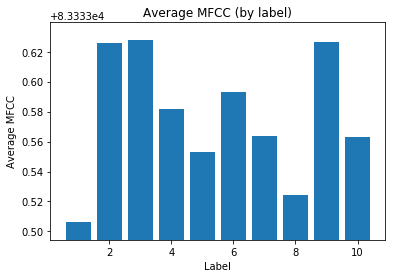

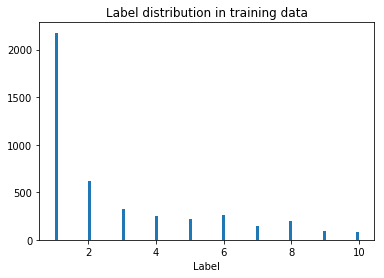

In [3]:
def visualize(X, y):
    label_count = 10
    labels = list(range(1, label_count + 1))
    data_by_label = {}
    for label in labels:
        idx = np.where(y == label)[0]
        data_by_label[label] = X[idx, :]

    plot_x = labels

    lower_plot_y = np.zeros((len(labels),))
    for i in range(label_count):
        lower_plot_y[i] = np.average(data_by_label[labels[i]][:, :56])

    middle_plot_y = np.zeros((len(labels),))
    for i in range(label_count):
        middle_plot_y[i] = np.average(data_by_label[labels[i]][:, 56:112])

    upper_plot_y = np.zeros((len(labels),))
    for i in range(label_count):
        upper_plot_y[i] = np.average(data_by_label[labels[i]][:, 112:168])

    rhythm_concat = np.concatenate([lower_plot_y, middle_plot_y, upper_plot_y]).max()
    avg_max = rhythm_concat.max()

    plt.figure()
    plt.title('Average rhythm in lower end bands (by label)')
    plt.ylabel('Average rhythm')
    plt.xlabel('Label')
    plt.ylim([0, 1.1 * avg_max])
    plt.bar(plot_x, lower_plot_y)

    plt.figure()
    plt.title('Average rhythm in middle bands (by label)')
    plt.ylabel('Average rhythm')
    plt.xlabel('Label')
    plt.ylim([0, 1.1 * avg_max])
    plt.bar(plot_x, middle_plot_y)

    plt.figure()
    plt.title('Average rhythm in higher end bands (by label)')
    plt.ylabel('Average rhythm')
    plt.xlabel('Label')
    plt.ylim([0, 1.1 * avg_max])
    plt.bar(plot_x, upper_plot_y)

    plt.figure()
    plot_x = labels
    plot_y = np.zeros((len(labels),))
    for i in range(label_count):
        plot_y[i] = np.average(data_by_label[labels[i]][:, 168:216])

    plt.title('Average chroma (by label)')
    plt.ylabel('Average chroma')
    plt.xlabel('Label')
    m = plot_y.max() - plot_y.min()
    plt.ylim([plot_y.min() - 0.1 * m, plot_y.max() + 0.1 * m])
    plt.bar(plot_x, plot_y)

    plt.figure()
    plot_x = labels
    plot_y = np.zeros((len(labels),))
    for i in range(label_count):
        plot_y[i] = np.average(data_by_label[labels[i]][:, 216:])

    plt.title('Average MFCC (by label)')
    plt.ylabel('Average MFCC')
    plt.xlabel('Label')
    m = plot_y.max() - plot_y.min()
    plt.ylim([plot_y.min() - 0.1 * m, plot_y.max() + 0.1 * m])
    plt.bar(plot_x, plot_y)

    plt.figure()
    plt.title('Label distribution in training data')
    plt.xlabel('Label')
    plt.hist(y, bins=100)

    plt.show()


print('Reading data from files...')
train_data, train_labels = Acc_train_data(), Acc_train_labels()
test_data = Acc_test_data()

print('Shaping data...')
X = train_data.values
y = train_labels.values[:, 0].astype(int)

visualize(X, y)

In the label histogram, the x-axis represents the label, where 1 is the "Pop rock" genre. As can be seen from the distribution, most of the songs are from that specific genre. This means that the training data is heavily unbalanced. The training data could be balanced by normalising the amount of entries with a specific label in the data.

Most of the data differs only by a factor of around 1-10% of the mean value. To amplify these differences, a scaler such as skicit-learn's StandardScaler [3] or RobustScaler [5] can be used.

Most notable differences between genres can be seen in the MFCC data. This would suggest that average MFCC would be a good indicator of music genre, and would serve as decent feature vector by itself. On the contrary, averages of rhythm by music genre label are harder to distinct from each other. A study by Tzanetakis and Cook [2], in which they noticed that timbral features perform better than non-timbral ones, implies the same finding.

## 3. Methods and experiments

The approach taken in the project is outlined in figure 1. Scikit-learn providies an algorithm cheatsheet in its documentation (figure 2), which proved highly useful for determining a good approach to the problem. The pipeline starts with splitting the training dataset, i.e. the feature and label datasets, into a training set and multiple test sets for error evaluation. Next, a feature matrix is built from feature data using a subset of features. The solution used only the MFCC data for a uniform, simple-to-understand training data set. Other possibilities include using the feature data matrix in its entirety, which can be really intensive, or a combination of pitch information and MFCC data, which can also be considered an effective choice [2].

The next step is to remove unwanted rows of training data, since the data set provided is very biased towards specific genres. The solution presented in this report ended up only experimenting with this step, since finding a good balance between sheer quantity of data and a non-biased data set proved to be difficult.

Like mentioned in section 2, the feature data points only differ by a factor of 1-10%. To amplify the differences, the feature data is scaled with a scaler. Scikit-learn provides a number of functional scaler alternatives that were experimented with in this project.

To find a model that maps input to a single label, a multiclass classifier, such as scikit-learn's OneVsRestClassifier [7], needs to be used. On the other hand, to find relative probabilities for all label candidates, a classifier such as DecisionTreeClassifier can be used [8]. The first is used for the accuracy score (amount of correct classifications) in the Kaggle competition. The latter is used for calculating the logarithmic loss score.

To find a good classifier model, a set of effective parameters have to be selected. The OneVsRestClassifier depends on an estimator, and optionally, a C-value, scale and kernel parameters [6, 7]. The DecisionTreeClassifier doesn't require mandatory parameters, but performs better when supplied with an optimal max_depth value. These classifier models can then be trained with the training data set.

The trained classifiers can be used to predict a possible label classification for a test set. Multiple test sets are used to evaluate the quality of the trained model. The test results are presented as an overall accuracy value, a log-loss value and a confusion matrix. These can be studied by hand to find possible deficiencies in the model.

After evaluating the model quality, the classifier model is used to find a classification for the competition data set. The results are written to a CSV file for submission to the Kaggle competition.

![title](flowchart.png)

_Figure 1._ Block diagram of the project structure and methods used.

![title](cheatsheet.png)

_Figure 2._ Scikit learn's cheatsheet used for determining best approach for the solution [9].

In [4]:
def preprocess_data(X):
    min_max_scaler = preprocessing.MinMaxScaler()
    robust_scaler = preprocessing.RobustScaler()
    standard_scaler = preprocessing.StandardScaler()
    # X = robust_scaler.fit_transform(X)    # I guess we got no Kaggle with this one
    # X = min_max_scaler.fit_transform(X)   # 59 %
    X = standard_scaler.fit_transform(X)    # 63 % Acc
    # X = extract_mfcc(X)                   # 55 %
    # X = extract_mfcc_and_chroma(X)        # 61,9 % with StandardScaler
    return X


def extract_mfcc(X):
    return X[:, RHYTHM_COUNT + CHROMA_COUNT:]


def extract_mfcc_and_chroma(X):
    return X[:, RHYTHM_COUNT:]


def symmetricize_data(X, y):
    occurances = np.bincount(y)[1:]
    max_count_per_label = np.min(occurances)

    label_count = 10
    new_X = np.zeros((max_count_per_label * label_count, X.shape[1]))
    new_y = np.zeros((max_count_per_label * label_count,), dtype=int)
    labels = range(1, label_count + 1)

    i = 0
    for label in labels:
        idx = np.where(y == label)[0]
        songs_with_label = X[idx, :]
        np.random.shuffle(songs_with_label)
        for j in range(max_count_per_label):
            new_X[i, :] = songs_with_label[j, :]
            new_y[i] = label
            i += 1

    return new_X, new_y


prepr_X = preprocess_data(X)

TEST_CASE_COUNT = 1
print(f'Generating {TEST_CASE_COUNT} test case(s)...')

test_X_cases = []
test_y_cases = []
test_size = 0.33
random_states = sample(range(1, 100), TEST_CASE_COUNT)
for random_state in random_states:
    _, test_X, _, test_y = train_test_split(
        prepr_X, y, test_size=test_size, random_state=random_state)
    test_X_cases.append(test_X)
    test_y_cases.append(test_y)

train_X, _, train_y, _ = train_test_split(
    prepr_X, y, test_size=test_size, random_state=42)

print('Creating classifier...')

C = 1
estimator = SVC(C=C, gamma='scale', random_state=42)
acc_classif = OneVsRestClassifier(estimator=estimator)
max_depth = 3
d_classif = DecisionTreeClassifier(max_depth=max_depth)

t = time.process_time()
print(f'Fitting accuracy predictor with C = {C}...')
acc_predictor = acc_classif.fit(train_X, train_y)

print(f'Fitting log-loss predictor with max_depth = {max_depth}...')
d_predictor = d_classif.fit(train_X, train_y)

elapsed_time = time.process_time() - t
print(f'Done. [{elapsed_time:.2f} s]')


Generating 1 test case(s)...
Creating classifier...
Fitting accuracy predictor with C = 1...
Fitting log-loss predictor with max_depth = 3...
Done. [18.02 s]


## 4. Results

The two predictor objects, 'acc_predictor' and 'd_predictor', the predictor accuracy scores (accuracy percentage and logarithmic loss) can be calculated. The code below uses built-in scikit-learn functions 'accuracy_score' and 'log_loss' for determining these scores. In addition, the code generates a confusion matrix for the accuracy test using scikit-learn.

In [7]:
t = time.process_time()
print(f'Running {TEST_CASE_COUNT} test cases (accuracy, log-loss)...')

for j in range(TEST_CASE_COUNT):
    case_X = test_X_cases[j]
    case_y = test_y_cases[j]
    y_hat_acc = acc_predictor.predict(case_X)
    y_hat_d = d_predictor.predict_proba(case_X)
    acc = 100 * accuracy_score(case_y, y_hat_acc)
    logloss = log_loss(case_y, y_hat_d)
    conf = confusion_matrix(case_y, y_hat_acc)
    print('C = {}, Accuracy: {:.2f}%'.format(C, acc))
    print('Log-loss: {:.2f}'.format(logloss))
    print('Confusion matrix for accuracy test:')
    print(conf)

sys.stdout.write('\n')
elapsed_time = time.process_time() - t
print('DONE. [{:.2f} s]'.format(elapsed_time))

print('Calculation for test data...')
t = time.process_time()
test_X = preprocess_data(test_data.values)
y_solution_acc = acc_predictor.predict(test_X).astype(int)
y_solution_d = d_predictor.predict_proba(test_X)
elapsed_time = time.process_time() - t
print('Elapsed time: [{:.2f} s]'.format(elapsed_time))

Running 1 test cases (accuracy, log-loss)...
C = 1, Accuracy: 78.12%
Log-loss: 1.54
Confusion matrix for accuracy test:
[[667  21   7   4   0   4   0   0   0   0]
 [ 36 180   4   0   1   0   1   0   1   0]
 [  8   5  82   0   0   1   1   0   0   0]
 [ 20   3   1  49   1   0   0   0   0   1]
 [ 29   3   2   1  28   0   1   1   0   0]
 [ 27   7   5   1   0  58   0   0   0   0]
 [ 27   4   3   1   0   2  11   0   0   0]
 [ 44   1   0   0   1   0   0  16   0   0]
 [  3   3   6   0   1   0   0   0  27   0]
 [ 19   0   0   2   0   0   0   1   0   7]]

DONE. [3.80 s]
Calculation for test data...
Elapsed time: [16.61 s]


The model performs slightly better with local data than Kaggle. The local accuracy score, at maximum, was 15% better than the Kaggle accuracy score. This implies that the test data is very different from the Kaggle data, and that the model might be subject to over-fitting.

According to the local tests, the model inaccurately labels other genres as "Pop rock". This is not surprising, since the training data is heavily biased in that regard.

The tables below represent the most interesting cases and their Kaggle scores.

_Table 1._ Kaggle competition, accuracy

| Approach        | Accuracy  |
| --- | --- |
| MFCC only with StandardScaler      | 0.60417 |
| MFCC and Chroma with StandardScaler      | 0.61996 |
| Standard Scaler with all features | 0.63779 |
| MFCC with MinMaxScaler | 0.55323 |

_Table 2._ Kaggle competition, log loss

| Approach        | Logarithmic loss  |
| --- | --- |
| Standard Scaler with all features | 0.23111 |
| MFCC and Chroma | 0.23031 |
| MFCC only with StandardScaler | 0.23031 |


In [8]:
def WriteAccuracy(data):
    df = pandas.DataFrame(
        data=data, columns=["Sample_label"],
        index=range(1, data.shape[0] + 1))
    df.index.name = "Sample_id"
    df.to_csv("Accuracy.csv")


def WriteLogLoss(data):
    cols = ["Class_" + str(i) for i in range(1, 11)]
    df = pandas.DataFrame(
        data=data, columns=cols,
        index=range(1, data.shape[0] + 1))
    df.index.name = "Sample_id"
    df.to_csv("LogLoss.csv")


print('Write to Accuracy.csv.')
WriteAccuracy(y_solution_acc)
print('Write to LogLoss.csv.')
WriteLogLoss(y_solution_d)
print('Done.')

Write to Accuracy.csv.
Write to LogLoss.csv.
Done.


## 5. Discussion/Conclusions

The results show that the model has room for improvement. There seem to be misclassifications when used with the presented training data. This is due to the biased nature of the data set, and implies that the training data should be further improved by manipulating it programmatically or by hand. One approach would be to make the row count of the offending label "Pop rock" smaller, or finding more data for the other labels.

The performance measures accuracy and logarithmic loss are relevant, but difficult to make use of with such a biased dataset. When validating the quality of the model locally, one must take caution since the accuracy scores might not represent the actual performance of the model in a real-life situation. This is often referred to as the Accuracy Paradox in literature.

The problem of music genre classification has been studied moderately in academic literature. Results achieved by other authors show accuracy scores of around 80% [1]. Suggestions for future improvement of the results include more sophisticated preprocessing of the training data and dimension reduction through suitable means, such as Randomized PCA or Spectral Embedding [9].

All in all, the scikit-learn framework proved to be easy to use, efficient and reliable for solving the classification problem.

## 6. References

[1] Li, Tao, Mitsunori Ogihara, and Qi Li. "A comparative study on content-based music genre classification." Proceedings of the 26th annual international ACM SIGIR conference on Research and development in informaion retrieval. ACM, 2003.

[2] Tzanetakis, George, and Perry Cook. "Musical genre classification of audio signals." IEEE Transactions on speech and audio processing 10.5 (2002): 293-302.

[3] Scikit StandardScaler http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

[4] Scikit MinMaxScaler http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler

[5] Scikit RobustScaler http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler

[6] Scikit SVC http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

[7] Scikit OneVsRestClassifier http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

[8] Scikit DecisionTreeClassifier http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

[9] Scikit Cheatsheet http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html